# scRNA UMAP's



In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import seaborn as sns
from scipy.sparse import csc_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import umap
import random
import multiprocessing
random.seed(123)
from joblib import Parallel, delayed
import os
import gc
import math
from PIL import Image
from PIL import ImageDraw
import sc_toolbox as sct
import warnings
warnings.filterwarnings('ignore')
import sys
import platform


/home/jupyter/libs/py_scrna/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## setting up the parameters for plotting 
fig_path = "/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_files/Certpro_figures/Plots_for_manuscript/"
sc.settings.figdir = fig_path
sc.settings.autosave=False
sc.set_figure_params(vector_friendly=True, dpi_save=300)

In [3]:
## reading the ALTRA scRNA object

In [4]:
adata=anndata.read_h5ad("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/py_files/ALTRA_certprod_harmonized.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 2059581 × 1231
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'sample.diseaseStatesRecordedAtVisit', 'sample.daysSinceFirstVisit', 'file.id', 'subset_grp', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L1_score', 'AIFI_L2', 'AIFI_L2_score', 'AIFI_L3', 'AIFI_L3_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_harmony_2', 'doublets_manual', 'AIFI_L3_new', 'St

# AIFI Level 3

In [6]:
# reading the color pallete file for plotting 
color_mapping_file = "/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_notebooks/files/input_files/Color_Annotation_and_Order_FINAL 1.csv"
color_df = pd.read_csv(color_mapping_file)

In [7]:
color_df

,xpos,label,color
0,1,SOX4+ naive CD4 T cell,#2B5777
1,2,Core naive CD4 T cell,#597FC6
2,3,ISG+ naive CD4 T cell,#072E77
3,4,CM CD4 T cell,#6793A4
4,5,GZMB- CD27+ EM CD4 T cell,#406B9C
...,...,...,...
66,67,CLP cell,#FCDB97
67,68,CMP cell,#5B3006
68,69,BaEoMaP cell,#3D1F15
69,70,Platelet,#5B3930


In [8]:
# Rename the column
color_df.rename(columns={'label': 'AIFI_L3'}, inplace=True)
color_df

,xpos,AIFI_L3,color
0,1,SOX4+ naive CD4 T cell,#2B5777
1,2,Core naive CD4 T cell,#597FC6
2,3,ISG+ naive CD4 T cell,#072E77
3,4,CM CD4 T cell,#6793A4
4,5,GZMB- CD27+ EM CD4 T cell,#406B9C
...,...,...,...
66,67,CLP cell,#FCDB97
67,68,CMP cell,#5B3006
68,69,BaEoMaP cell,#3D1F15
69,70,Platelet,#5B3930


In [9]:
# Create a dictionary for mapping cell types to colors
color_dict = pd.Series(color_df.color.values, index=color_df.AIFI_L3).to_dict()

In [10]:
color_dict

{'SOX4+ naive CD4 T cell': '#2B5777',
 'Core naive CD4 T cell': '#597FC6',
 'ISG+ naive CD4 T cell': '#072E77',
 'CM CD4 T cell': '#6793A4',
 'GZMB- CD27+ EM CD4 T cell': '#406B9C',
 'GZMB- CD27- EM CD4 T cell': '#233C5B',
 'ISG+ memory CD4 T cell': '#5480A3',
 'KLRF1- GZMB+ CD27- memory CD4 T cell': '#628088',
 'Naive CD4 Treg': '#8EB5D7',
 'Memory CD4 Treg': '#001A9A',
 'KLRB1+ memory CD4 Treg': '#3B76C1',
 'GZMK+ memory CD4 Treg': '#A3B7C2',
 'Memory CD8 Treg': '#C3D1DA',
 'KLRB1+ memory CD8 Treg': '#C7E0C6',
 'DN T cell': '#656E68',
 'Proliferating T cell': '#AEAEB0',
 'SOX4+ naive CD8 T cell': '#465F32',
 'Core naive CD8 T cell': '#63A686',
 'ISG+ naive CD8 T cell': '#869A94',
 'CM CD8 T cell': '#6D9F5E',
 'GZMK+ CD27+ EM CD8 T cell': '#95BDA1',
 'KLRF1- GZMB+ CD27- EM CD8 T cell': '#59895F',
 'GZMK- CD27+ EM CD8 T cell': '#314937',
 'KLRF1+ GZMB+ CD27- EM CD8 T cell': '#4E695B',
 'ISG+ memory CD8 T cell': '#94C0AD',
 'CD8aa': '#7ECDAD',
 'SOX4+ Vd1 gdT': '#B6D7C8',
 'Naive Vd1 gd

In [12]:
# Get the list of colors in the same order as the categories in 'AIFI_L3'
palette = [color_dict[cell_type] for cell_type in adata.obs['AIFI_L3'].cat.categories]

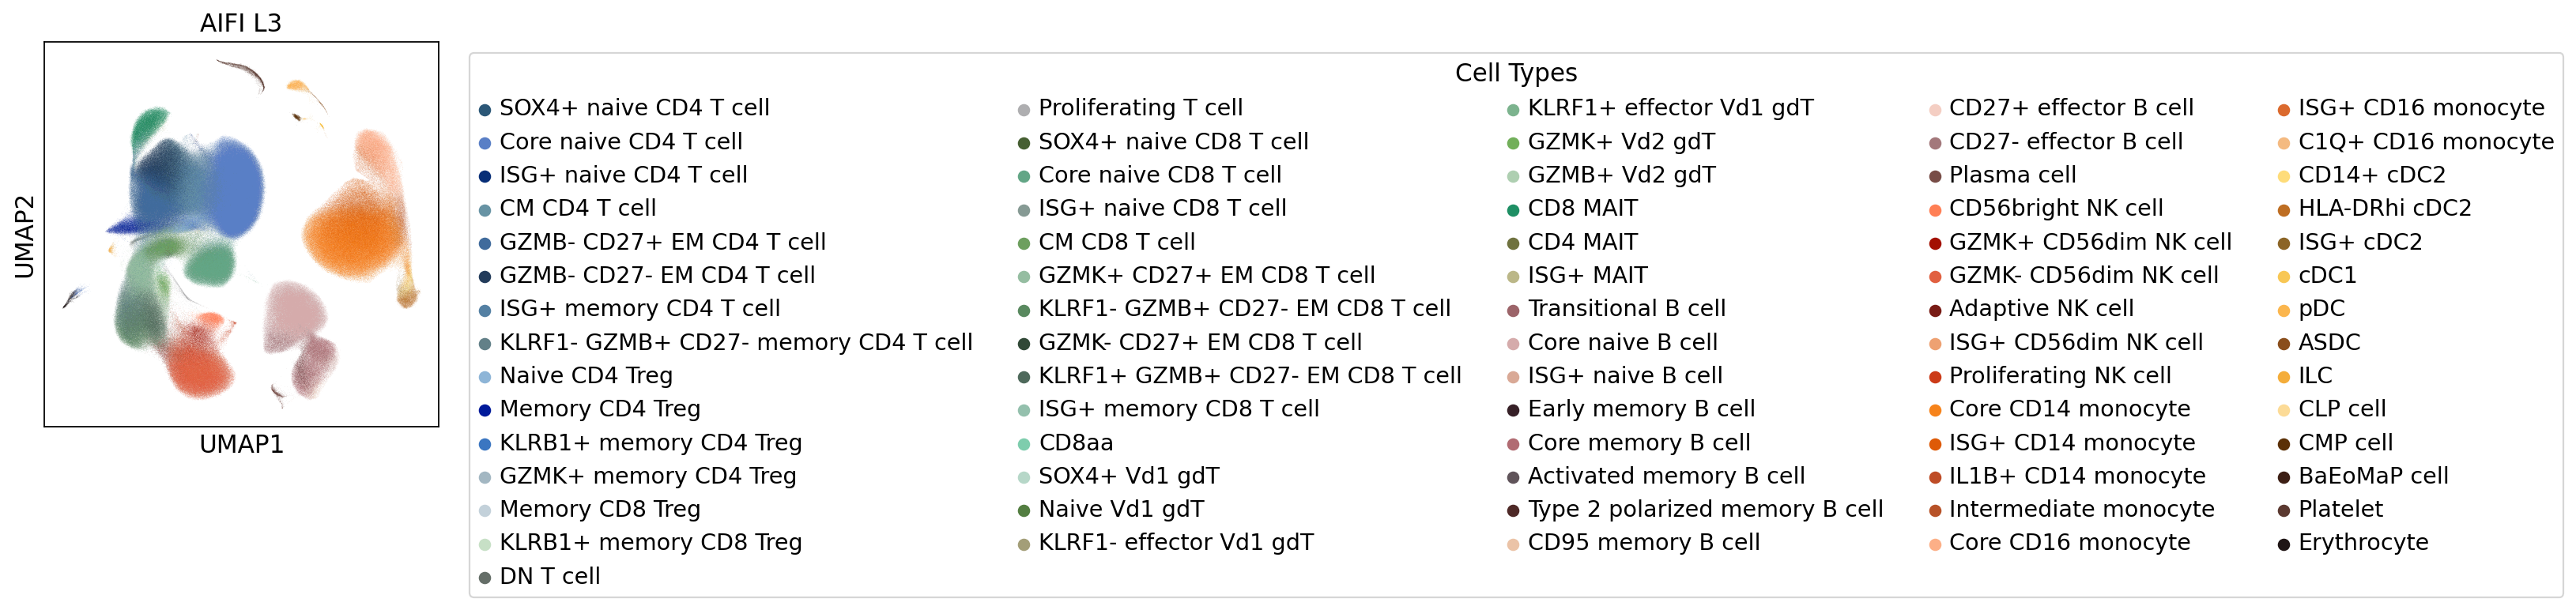

In [13]:
# Convert the color values in the dictionary to a list
color_list = list(color_dict.values())

# Generate the UMAP plot and save the figure
fig, ax = plt.subplots()
sc.pl.umap(adata, color='AIFI_L3', palette=palette, title='AIFI L3', ax=ax, show=False)

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
# Reorder handles and labels based on the color_dict
ordered_handles = [handles[labels.index(AIFI_L3)] for AIFI_L3 in color_dict.keys()] ## allocates the color for each celltype in AIFI L3
ordered_labels = list(color_dict.keys())

# Create a new legend with the ordered handles and labels
ax.legend(ordered_handles, ordered_labels, title='Cell Types',bbox_to_anchor=(1.05, 1), loc='upper left',ncol=5)


# Display the plot
plt.show()
fig.savefig(f"{fig_path}/FigS2C.pdf", bbox_inches='tight')

## AIFI Level 2

In [26]:
color_dict2 = {'ASDC': '#8A4E1C','CD8aa': '#7ECDAD','CD14 monocyte': '#F6831B','CD16 monocyte': '#FCAF87',
'CD56bright NK cell': '#FF7F55','CD56dim NK cell': '#E16040','DN T cell': '#656E68',
'Effector B cell': '#F4CEC3','Erythrocyte': '#1F1515','ILC': '#F4AD3A','Intermediate monocyte': '#B75228',
'MAIT': '#BBB788','Memory B cell': '#B16B72','Memory CD8 T cell': '#6D9F5E','Memory CD4 T cell': '#6793A4',
'Naive B cell': '#D5ABAB','Naive CD4 T cell': '#597FC6','Naive CD8 T cell': '#63A686','Plasma cell': '#784D47',
'Platelet': '#5B3930','Progenitor cell':'#3D1F15','Proliferating T cell': '#AEAEB0','Proliferating NK cell': '#CC3B18',
'Transitional B cell': '#9C6469','Treg': '#8EB5D7','cDC1': '#F8C755','cDC2': '#FEDC7A',
               'gdT': '#72AF5A','pDC': '#FBB64E'
              }




In [27]:
# Get the list of colors in the same order as the categories in 'AIFI_L3'
palette_l2 = [color_dict2[cell_type] for cell_type in adata.obs['AIFI_L2'].cat.categories]

In [28]:
len(palette_l2)

29

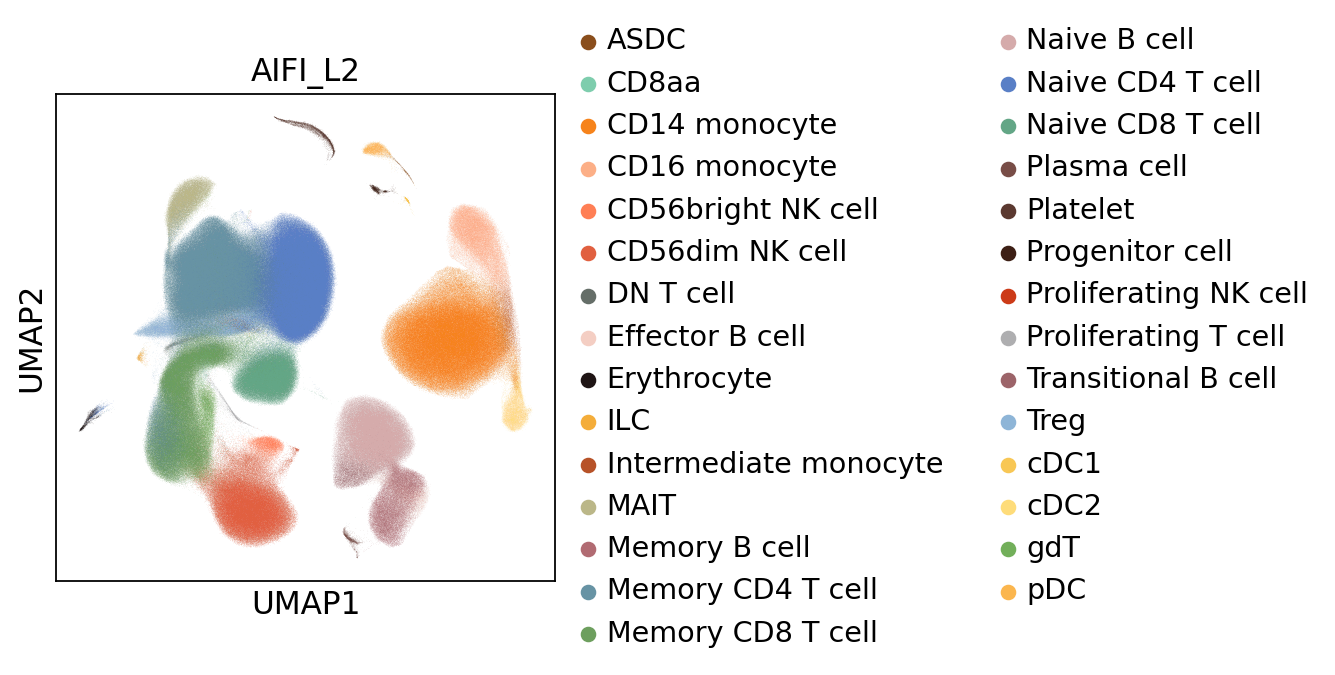

In [29]:
sc.pl.umap(adata, color='AIFI_L2', 
           palette=palette_l2,
           save="Fig_S2B.pdf")


# AIFI Level 1

In [30]:
# make the cell type match the database
adata.obs['AIFI_L1_5'] = adata.obs['AIFI_L2'].astype('str').copy()
adata.obs.loc[adata.obs['AIFI_L1_5'].str.contains('CD4'), 'AIFI_L1_5'] = 'CD4_T'
adata.obs.loc[adata.obs['AIFI_L1_5'].str.contains('CD8'), 'AIFI_L1_5'] = 'CD8_T'
adata.obs.loc[adata.obs['AIFI_L1_5'].isin(['DN T cell', 'MAIT',
    'Proliferating T cell']), 'AIFI_L1_5'] = 'Other_T'
adata.obs.loc[adata.obs['AIFI_L1_5'].str.contains('monocyte'), 'AIFI_L1_5'] = 'mono'
adata.obs.loc[adata.obs['AIFI_L1_5'].str.contains('DC'), 'AIFI_L1_5'] = 'DC'
adata.obs.loc[adata.obs['AIFI_L1_5'].str.contains('NK'), 'AIFI_L1_5'] = 'NK'
adata.obs.loc[
    adata.obs['AIFI_L1_5'].isin(['Naive B cell', 'Transitional B cell']), 
    'AIFI_L1_5'] = 'Naive B cell'
adata.obs.loc[
    adata.obs['AIFI_L1_5'].isin(['Effector B cell', 'Memory B cell']), 
    'AIFI_L1_5'] = 'Memory B cell'
adata.obs.loc[adata.obs['AIFI_L1_5'].isin(['Platelet','Erythrocyte','Progenitor cell']), 
    'AIFI_L1_5'] = 'Other'

In [31]:
adata.obs['AIFI_L1_5'].value_counts()

AIFI_L1_5
CD4_T            852132
mono             353390
CD8_T            320537
NK               175087
Naive B cell     131176
Memory B cell     58786
Treg              58075
Other_T           41744
gdT               32750
DC                22937
Other             10058
Plasma cell        2048
ILC                 861
Name: count, dtype: int64

In [32]:
color_dict1 = {
    'CD4_T': '#597FC6', 'CD8_T': '#63A686', 'DC': '#BE6E23', 'ILC': '#F4AD3A',
    'Memory B cell': '#B16B72', 'NK': '#A31001', 'Naive B cell': '#D5ABAB',
    'Other': '#5B3930', 'Other_T': '#1E8F64', 'Plasma cell': '#784D47',
    'Treg': '#8EB5D7', 'gdT': '#72AF5A', 'mono': '#FCAF87'
}


In [41]:
# Get the list of colors in the same order as the categories in 'AIFI_L3'
adata.obs['AIFI_L1_5'] = adata.obs['AIFI_L1_5'].astype('category')
palette_1_5 = [color_dict1[cell_type] for cell_type in adata.obs['AIFI_L1_5'].cat.categories]
palette_1_5

['#597FC6',
 '#63A686',
 '#BE6E23',
 '#F4AD3A',
 '#B16B72',
 '#A31001',
 '#D5ABAB',
 '#5B3930',
 '#1E8F64',
 '#784D47',
 '#8EB5D7',
 '#72AF5A',
 '#FCAF87']

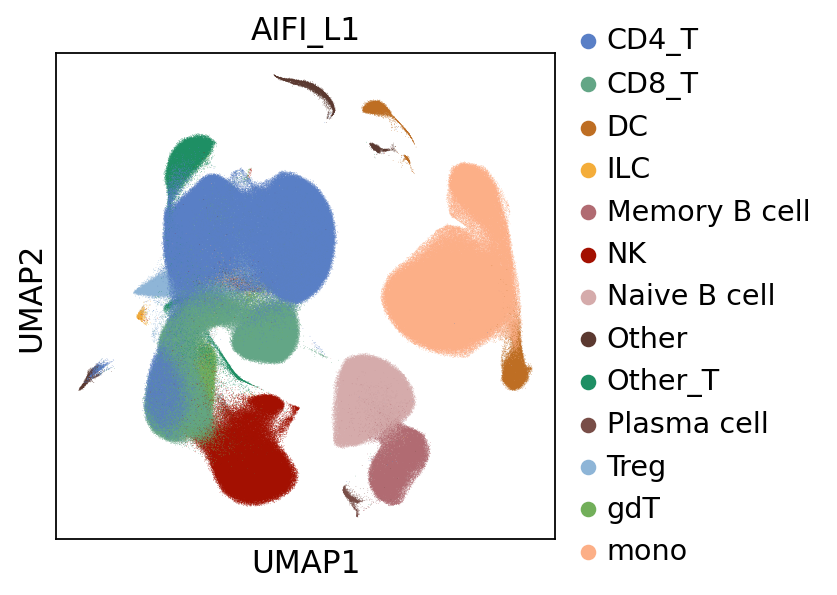

In [42]:
sc.pl.umap(adata, color='AIFI_L1_5', palette=palette_1_5,size=0.3,title='AIFI_L1'
           ,save="FigS2_A.pdf"
          )

In [47]:
print(f"Python Version: {sys.version}")
print(f"Platform: {platform.system()} {platform.release()}")
print(f"Architecture: {platform.architecture()}")

Python Version: 3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:43:09) [GCC 12.3.0]
Platform: Linux 5.15.0-1066-gcp
Architecture: ('64bit', 'ELF')
